In [1]:
import bagpy
from bagpy import bagreader
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

#%matplotlib notebook

In [2]:
bag_name = "first_fly.bag"
bag_name1 = "second_fly.bag"


def get_csv(bag_name):
    
    data_dict = {}
    
    # Read bag
    b = bagreader(bag_name)
    
    for topic in b.topics: 
        data = b.message_by_topic(topic)
        data_dict['{}'.format(topic)] = pd.read_csv(data)
        
    return data_dict


        

In [3]:
exp = get_csv(bag_name); exp1 = get_csv(bag_name1)

[INFO]  Data folder first_fly already exists. Not creating.
[INFO]  Data folder second_fly already exists. Not creating.


# Open bags


In [34]:
def open_bags(dir_path): 
    bags = {}
    for bag in os.listdir(dir_path): 
        print("[INFO] Bag name is: {}".format(bag))
        bags["{}".format(bag)] = get_csv(bag)
    return bags

bags = open_bags()

# How to repair broken bags: http://wiki.ros.org/rosbag/Commandline#reindex
# https://answers.ros.org/question/40116/rosbag-file-cannot-be-made-bagactive/

In [4]:
odometry = exp['/bebop/odometry']
#joy = pd.read_csv(csv_files[1])

odometry1 = exp1['/bebop/odometry']
#joy1 = pd.read_csv(csv_files[1])

In [5]:
x_pos = odometry['pose.pose.position.x']
y_pos = odometry['pose.pose.position.y']
z_pos = odometry['pose.pose.position.z']

x1_pos = odometry1['pose.pose.position.x']
y1_pos = odometry1['pose.pose.position.y']
z1_pos = odometry1['pose.pose.position.z']

In [6]:
def plot_2d_trajectory(odometry, multiple=False):
    
    x_pos = odometry['pose.pose.position.x']
    y_pos = odometry['pose.pose.position.y']
    
    if not multiple: 
        plt.figure()
    plt.plot(x_pos, y_pos)
    plt.title('2D trajectory')
    plt.xlabel('X position [m]')
    plt.ylabel('Y position [m]')

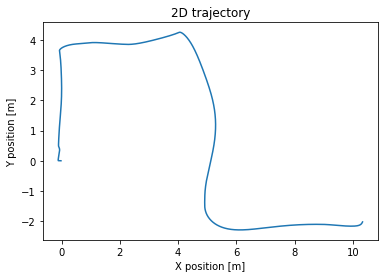

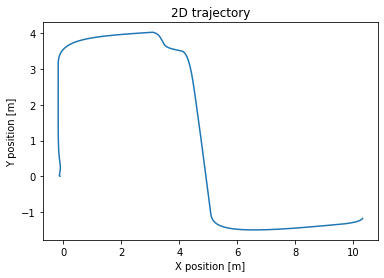

In [7]:
plot_2d_trajectory(odometry)
plot_2d_trajectory(odometry1)

<Figure size 432x288 with 0 Axes>

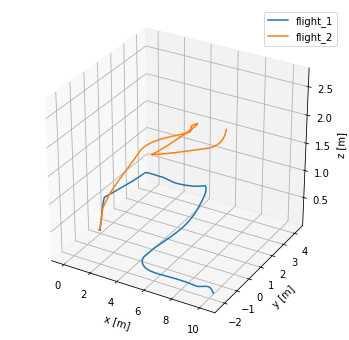

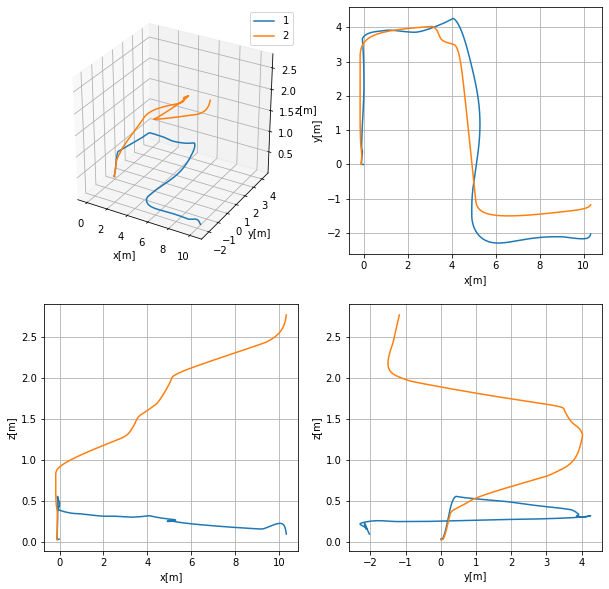

In [52]:
# Could basically plot in different colors depending on linear velocity
#plt.figure()
#plot_2d_trajectory(odometry, multiple=True)
#plot_2d_trajectory(odometry1, multiple=True)

# TODO: Plot in different colors depending on linear velocity? 
# TODO: Add labyrinth to plots
# TODO: Add different plots depending on maze passage time 
plt.figure()
plot_3d_trajectory([odometry, odometry1], multiple=True)
plot_3d_2d_trajectories([odometry, odometry1])

## Plot 3D trajectory 

In [54]:
def plot_3d_trajectory(odometry, multiple=False):
    
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    
    
    if type(odometry) == list: 
        x_, y_, z_  = [], [], []
        for odom in odometry: 
            x_.append(odom['pose.pose.position.x'])
            y_.append(odom['pose.pose.position.y'])
            z_.append(odom['pose.pose.position.z'])
        
        cnt = 0
        for x, y, z in zip(x_, y_, z_): 
            cnt += 1
            ax.plot(x, y, z, label="flight_{}".format(cnt))
        plt.legend()
            
            
    else: 
        x_pos = odometry['pose.pose.position.x']
        y_pos = odometry['pose.pose.position.y']
        z_pos = odometry['pose.pose.position.z']        
        ax.plot(x_pos, y_pos, z_pos)
    
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
    ax.set_zlabel('z [m]')
    
    plt.show()  
    
def plot_3d_2d_trajectories(odometry, multiple=False):

    fig, ax = plt.subplots(2, 2, figsize=(10, 10))    
    
    if type(odometry) == list: 
        x_, y_, z_  = [], [], []
        for odom in odometry: 
            x_.append(odom['pose.pose.position.x'])
            y_.append(odom['pose.pose.position.y'])
            z_.append(odom['pose.pose.position.z'])
        
        cnt = 0
        for x, y, z in zip(x_, y_, z_): 
            cnt += 1
            if cnt == 1:
                ax[0, 0].remove()
                ax_3d = fig.add_subplot(2, 2, 1, projection="3d")                
            ax_3d.plot(x, y, z, label="{}".format(cnt))            
            ax[0, 1].plot(x, y);           
            ax[1, 0].plot(x, z); 
            ax[1, 1].plot(y, z); 
            
            
        plt.legend()     
            
    else: 
        x = odometry['pose.pose.position.x']
        y = odometry['pose.pose.position.y']
        z = odometry['pose.pose.position.z']
        
        #ax.plot(x_pos, y_pos, z_pos)
        
        ax[0, 0].remove()
        ax_3d = fig.add_subplot(2, 2, 1, projection='3d')        
        # Plot trajectories 
        ax_3d.plot(x, y, z)
        ax[0, 1].plot(x, y); 
        ax[1, 0].plot(x, z); 
        ax[1, 1].plot(y, z); 
    
    ax_3d.set_xlabel('x[m]'); ax_3d.set_ylabel('y[m]'); ax_3d.set_zlabel('z[m]')
    ax[0, 1].grid(); ax[0, 1].set_xlabel('x[m]'); ax[0, 1].set_ylabel('y[m]')
    ax[1, 0].grid(); ax[1, 0].set_xlabel('x[m]'); ax[1, 0].set_ylabel('z[m]')
    ax[1, 1].grid(); ax[1, 1].set_xlabel('y[m]'); ax[1, 1].set_ylabel('z[m]')
    
    plt.show()  
    

## Test define zones 


In [66]:
def define_zones(img_width, img_height, edge_offset, rect_width):
        
        # img center
        cx, cy = img_width/2, img_height/2
        # 1st zone
        cx1, cy1 = cx/2, cy/2
        # 2nd zone
        cx2, cy2 = cx + cx1, cy + cy1
        
        # Define offsets from edge
        if edge_offset < 1: 
            height_edge = edge_offset * img_height
            width_edge = edge_offset/2 * img_width

        # Zone definition 
        if rect_width < 1: 
            r_width = rect_width * img_width

        height_rect = ((cx1 - r_width, height_edge), (cx1 + r_width, img_height - height_edge))
        yaw_rect = ((width_edge, cy - r_width), (cx - width_edge, cy + r_width))
        pitch_rect = ((cx2 - r_width, height_edge), (cx2 + r_width, img_height - height_edge))
        roll_rect = ((cx + width_edge, cy-r_width), (img_width - width_edge), (cy + r_width))
        
        return height_rect, yaw_rect, pitch_rect, roll_rect

In [67]:
from PIL import Image, ImageDraw
from matplotlib.pyplot import imshow
import numpy as np

# Bar plot for evaluating human ratings using NASA TLX


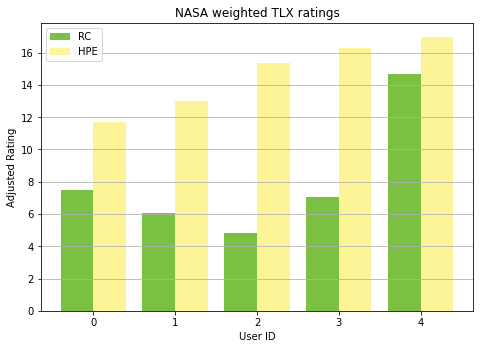

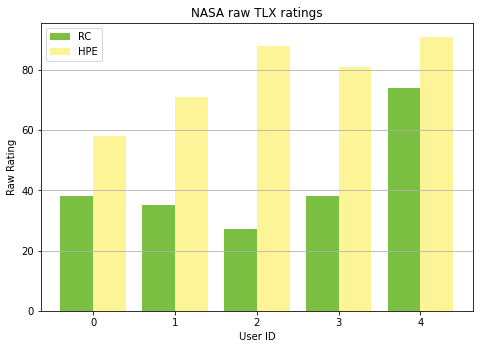

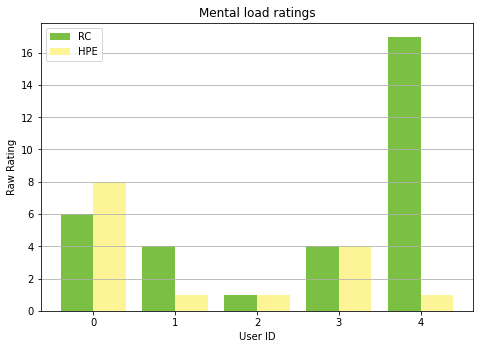

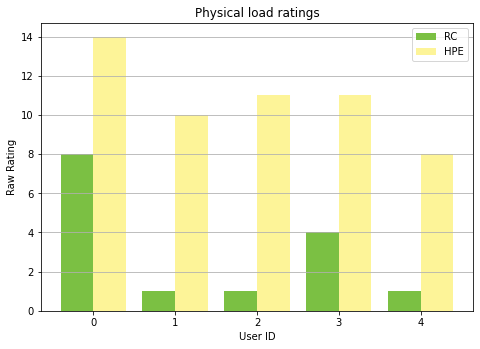

In [32]:
origin_dir = "hpe_paper"

# Weighted rating 
X = np.arange(5)
rc_w_ratings = [7.467, 6.067, 4.8, 7.067, 14.667]
hpe_w_ratings = [11.73, 13, 15.33333333, 16.26666667, 17]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X - 0.2, rc_w_ratings, color = "#7bc043", width = 0.4)
ax.bar(X + 0.2, hpe_w_ratings, color = '#fdf498', width = 0.4)
ax.grid(axis="y")
ax.set_title("NASA weighted TLX ratings")
ax.set_xlabel("User ID")
ax.set_ylabel("Adjusted Rating")
ax.legend(labels=["RC", "HPE"])
fig.savefig("./{}/nasa_weighted_tlx_ratings.svg".format(origin_dir))

# Raw rating 
rc_raw_ratings = [38, 35, 27, 38, 74]
hpe_raw_ratings = [58, 71, 88, 81, 91]
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(X - 0.2, rc_raw_ratings, color="#7bc043", width=0.4)
ax.bar(X + 0.2, hpe_raw_ratings, color="#fdf498", width=0.4)
ax.grid(axis="y")
ax.set_title("NASA raw TLX ratings")
ax.set_xlabel("User ID")
ax.set_ylabel("Raw Rating")
ax.legend(labels=["RC", "HPE"])
fig.savefig("./{}/nasa_raw_tlx_ratings.svg".format(origin_dir))


# Mental demand 

md_raw_rc  = [6, 4, 1, 4, 17]
md_raw_hpe = [8, 1, 1, 4, 1]
rc_w_ratings = ...; 
hpe_w_ratings = ...; 
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(X - 0.2, md_raw_rc, color="#7bc043", width=0.4)
ax.bar(X + 0.2, md_raw_hpe, color="#fdf498", width=0.4)
ax.grid(axis="y")
ax.set_title("Mental load ratings")
ax.set_xlabel("User ID")
ax.set_ylabel("Raw Rating")
ax.legend(labels=["RC", "HPE"])
fig.savefig("./{}/mental_demand_tlx_ratings.svg".format(origin_dir))



# Physical demand 
pd_raw_rc  = [8, 1, 1, 4, 1]
pd_raw_hpe = [14, 10, 11, 11, 8]
# TODO: Add weighted ratings 
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(X - 0.2, pd_raw_rc, color="#7bc043", width=0.4)
ax.bar(X + 0.2, pd_raw_hpe, color="#fdf498", width=0.4)
ax.grid(axis="y")
ax.set_title("Physical load ratings")
ax.set_xlabel("User ID")
ax.set_ylabel("Raw Rating")
ax.legend(labels=["RC", "HPE"])
fig.savefig("./{}/physical_demand_tlx_ratings.svg".format(origin_dir))



# Nice colors for plots can be found here: https://digitalsynopsis.com/design/beautiful-color-palettes-combinations-schemes/


# Evaluating zone control for rectangles 


In [ ]:

img_height = 480
img_width = 640
img = Image.new('RGB', (img_width, img_height), color = 'white')

height_rect, yaw_rect, pitch_rect, roll_rect = define_zones(img_width, img_height, 0.1, 0.05)

img1 = ImageDraw.Draw(img)  
img1.rectangle(height_rect, fill ="blue", outline ="red")
img1.rectangle(yaw_rect, fill="green")
img1.rectangle(roll_rect, fill="yellow")
img1.rectangle(pitch_rect, fill="blue")
imshow(np.asarray(img))